In the article, I'll show you that gradient boosting can be seen as a \"blind\" gradient descent. The gradient boosting pursues the same goal as the gradient descent, except it doesn't have a function for which we want to find a minimum, and yet the steps it takes can get you closer to it. That's what I mean by \"blind\". Gradient boosting optimizes the function which it doesn't see.

In [1605]:
from IPython.display import display, HTML

display(HTML("""
<style>
    p img { margin: 0 auto; }
    .side-scroll {
        overflow-x: auto;
    }
    .side-scroll .MathJax_Display {
        margin: 0em 0em 1em 0em;
    }
    .side-scroll::-webkit-scrollbar {
         -webkit-appearance: none;
         width: 3px;
         height: 4px;
         border: 1px solid rgb(235, 232, 232);
         border-radius: 4px;
     }
     .side-scroll::-webkit-scrollbar-thumb {
         border-radius: 4px;
         background-color: rgba(0,0,0,.5);
         box-shadow: 0 0 1px rgba(255,255,255,.5);

     } 
    h3, h4, h5, h6 {
        margin-top: 1.5rem !important;
    }
</style>
"""))

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

ggplot_colors = plt.rcParams['axes.prop_cycle']
colors = np.array([c['color'] for c in ggplot_colors])

matplotlib.rc('font', size=15)

## Introduction

In the recent decade, gradient-based methods enormously impacted the machine learning field. I have a hard time imagining the most impressive achievements in the field being possible without them. Even if you're using some application powered by machine learning, there is a high chance that a gradient-based method is being used somewhere under the hood. Certain methods are not hiding that, and the relation to the gradient-based method can be clearly spotted just from the name alone. In this article, I want to focus on two methods: Gradient Boosting and Gradient Descent. Their apparent relation to the technique is not the only similarity that they share. There exists an interesting parallel between these two methods. Hopefully, by the end of this article, I will be able to convince you that gradient boosting can be seen as a "blind" gradient descent. To better understand what I mean by that, let's first look at the figure below.

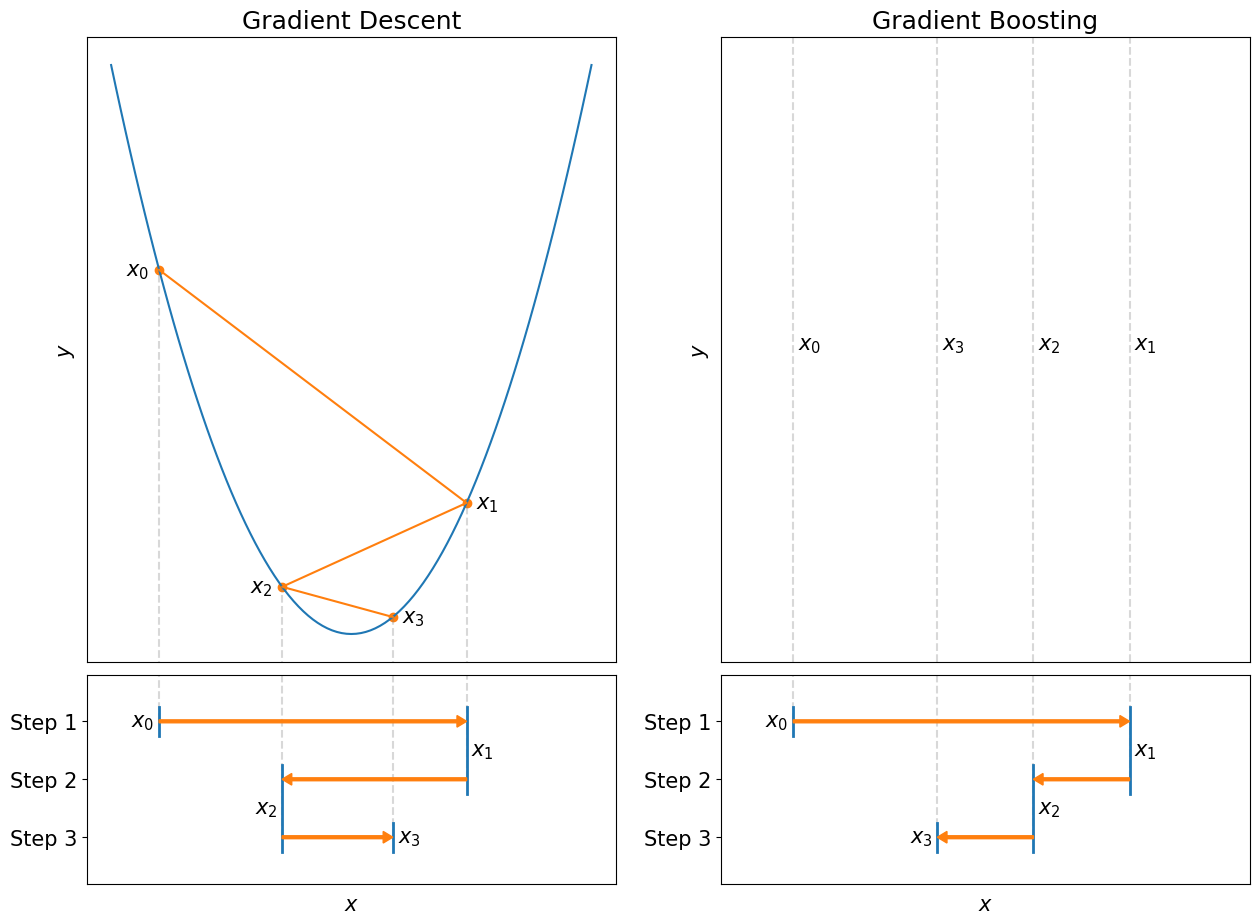

In [1575]:
def q(x):
    x = np.asarray(x)
    return x**2 - 1

def optimise(x0, alpha, num_steps):
    x = x0
    x_trace = [x]

    for _ in range(num_steps):
        x = x - alpha * 2 * x
        x_trace.append(x)
        
    return x_trace
    
def init_ticks():
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel(r"$x$")

xs = np.linspace(-100, 100, 101)

x0 = -80
num_steps = 3
x_trace_1 = optimise(x0, alpha=0.8, num_steps=num_steps)
x_trace_2 = [-80, 60, 20, -20]

fig, axes = plt.subplots(2, 2, figsize=(15, 11), gridspec_kw={"height_ratios": [3, 1]})

plt.sca(axes[0, 0])
plt.title(r"Gradient Descent")
plt.plot(xs, q(xs))
plt.plot(x_trace_1, q(x_trace_1))
plt.scatter(x_trace_1, q(x_trace_1), color=colors[1])

ylim = plt.gca().get_ylim()
for i in range(num_steps+1):
    is_left_to_right = (x_trace_1[i] - x_trace_1[i-1]) < 0 if i > 0 else True
    x = x_trace_1[i]
    y = q(x)
    plt.plot([x, x], [-1000, y], color="grey", alpha=0.3, linestyle="--")
    plt.annotate(
        rf"$x_{i}$",
        (x-4 if is_left_to_right else x+4, y-100),
        ha="right" if is_left_to_right else "left",
    )

plt.ylim(*ylim)
init_ticks()
plt.ylabel(r"$y$")
gg_lim = plt.gca().get_xlim()

plt.sca(axes[0, 1])
plt.title(r"Gradient Boosting")
for i in range(num_steps+1):
    x = x_trace_2[i]
    plt.plot([x, x], [-1, 1], color="grey", alpha=0.3, linestyle="--")
    plt.annotate(
        rf"$x_{i}$",
        (x + 2, 0),
    )

plt.xlim(*gg_lim)
plt.ylim(-1, 1)
init_ticks()
plt.ylabel(r"$y$")

for col, trace in zip([0, 1], [x_trace_1, x_trace_2]):
    plt.sca(axes[1, col])
    plt.xticks([], [])
    plt.xlabel(r"$x$")
    plt.yticks(-np.arange(1, num_steps+1), [f"Step {i}" for i in range(1, num_steps+1)])
    plt.ylim(-num_steps-0.8, -0.2)
    plt.xlim(*gg_lim)

    for i in range(len(x_trace_1) - 1):
        x, y = trace[i], -(i+1)
        dx = trace[i+1]-trace[i]
        plt.arrow(
            x=x,
            y=y,
            dx=dx,
            dy=0,
            length_includes_head=True,
            shape="full",
            width=0.05,
            color=colors[1],
            head_length=4,
            head_width=0.2,
            zorder=1000,
        )
        is_left_to_right = dx > 0

        vertical_bounds = [y - 0.25, y + 1.25] if i != 0 else [y - 0.25, y + 0.25]
        plt.plot([x, x], vertical_bounds, color=colors[0], linewidth=2)
        plt.plot([x, x], [y, 0], color="grey", alpha=0.3, linestyle="--", zorder=0)
        
        plt.annotate(
            rf"$x_{i}$",
            (x-2 if is_left_to_right else x+2, (y-0.1 if i == 0 else y+0.4)),
            ha="right" if is_left_to_right else "left",
        )

        if i+2 == len(trace):
            last_x = trace[i+1]
            plt.plot([last_x, last_x], [y - 0.25, y + 0.25], color=colors[0], linewidth=2)
            plt.plot([last_x, last_x], [y, 0], color="grey", alpha=0.3, linestyle="--", zorder=0)
            plt.annotate(
                rf"$x_{i+1}$",
                (last_x-2 if not is_left_to_right else last_x+2, y-0.1),
                ha="right" if not is_left_to_right else "left",
            )

plt.subplots_adjust(hspace=0.03)
plt.show()

The figure shows how two methods are trying to solve the same type of problem. The gradient descent tries to find a minimum of the function \\(x^2\\) (shown in blue, top-left) by iteratively updating the initial guess \\(x_0\\). The algorithm goes through 3 steps until we stop it at \\(x_3\\). Below the graph (bottom-left), we can see how value \\(x\\) changes after each gradient descent step. Gradient boosting's side, on the other hand, doesn't have a graph even though the parameter \\(x\\) is also being updated iteratively (bottom-right). The gradient boosting pursues the same goal, except it doesn't have a function for which we want to find a minimum, and yet the steps it takes can get you closer to it. That’s what I mean by “blind” - gradient boosting optimizes the function it doesn’t see.

It might sound strange at first since, at the very least, it's not clear what problem gradient boosting is optimising for! Unlike gradient descent, the gradient boosting method must be "trained" to perform a particular task. Another way to say it is that it has to experience many actual gradient descent optimizations from a specific set of "similar" problems to be able to solve new problems in the future when the function might not be available. You can think of it in terms of the following analogy. Let's say you have a robot that you can control remotely on Mars. Suppose you frequently take your robot for a drive through similar routes near the robot's base. In that case, it should be possible for you to return the robot to the base even if it loses its ability to send you sensory information like video, audio, etc. (so that you cannot get any feedback for your input). On the other hand, the task would be almost impossible for somebody without robot-driving experience in that particular area of Mars. The gradient boosting is quite similar to the robot driver. First, it learns from many similar gradient descent tasks and later performs optimisations when no information about the function is available.

We will base our main discussion on the theoretical part of the [XGBoost paper](https://arxiv.org/pdf/1603.02754.pdf), but first, I believe reviewing a couple of mathematical concepts might be important. We start our discussion with one-dimensional optimisation problems. Next, we will cover a specific family of functions, namely sum of squared errors (SSE). These discussions would help us to build the mathematical intuition needed for the main topic. And at the end, we will spend time understanding how the XGBoost model works and conclude the article with the main topic.

- [One-dimensional optimization](#one-dimensional-optimization)
    - [Gradient-descent](#gradient-descent)
    - [Newton's method](#newtons-method)

- [Sum of squared error (SSE)](#sum-of-squared-error-sse)
    - [Regular SSE](#regular-sse)
    - [Weighted SSE](#weighted-sse)
    - [Regularised SSE](#regularised-sse)
    
- [Gradient Boosting Decision Trees (GBDT)](#gradient-boosting-decision-trees)
    - [Decision trees](#decision-trees)
    - [Loss function](#loss-function)
    - [Symmetry breaking](#symmetry-breaking)
    - [Approximation of the loss function](#approximation-of-the-loss-function)
    - [Optimial solution](#optimial-w_kr)
    - [Relation to the Newton's method](#relation-to-the-newtons-method)
    - [The “blind” gradient descent](#the-blind-gradient-descent)

## One-dimensional optimization

### Gradient descent

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a method for finding a local minimum of the function by iteratively updating our initial guess of where the minimum could be. Typically we have a function \\(\,f(x)\\) and a starting guess which we call \\(x_0\\) (it doesn't have to be a good guess). Furthermore, the function \\(\,f\\) must be [differentiable](https://en.wikipedia.org/wiki/Differentiable_function); otherwise, we might be unable to compute the gradient at every point of the function, and the method won't work. And since we're focusing on one-dimensional optimisation we will use the term "derivative" instead of "gradient" in the following discussions since it's a bit more precise.

We start the optimization process by evaluating the derivative at the initial point \\(\,x_0\\), which we write as \\(\,f'(x_0)\\). The derivative points to the direction in which the function increases. Since we are interested in the minimum, it will be enough to focus on the opposite direction (i.e., negative of the derivative). Next, we take one step in that direction and see where we land. We keep repeating the process until we converge to a fixed point, or we get tired of looking for the minimum, which might not even exist. Mathematically it can be represented with a straightforward equation

$$
\begin{align}
x_{t+1} &= x_t - \alpha f'(x_t) \\
    &= x_t - \alpha g_t
\end{align}
$$

where \\(\,x_t\\) represents our improved guess after \\(t\\) steps, and \\(\alpha\\) is a positive constant that controls the size of the steps we take after each iteration. In addition, the notation of the derivative has changed since we replaced it with the \\(g_t = f'(x_t)\\) (\\(g\\) stands for "gradient"), which implicitly assumes that the derivative is evaluated at a point which was obtained at step \\(t\\). Change may look unnecessary, but it will become more useful in the later sections.

Two examples of the gradient descent optimisation process are in the image below.

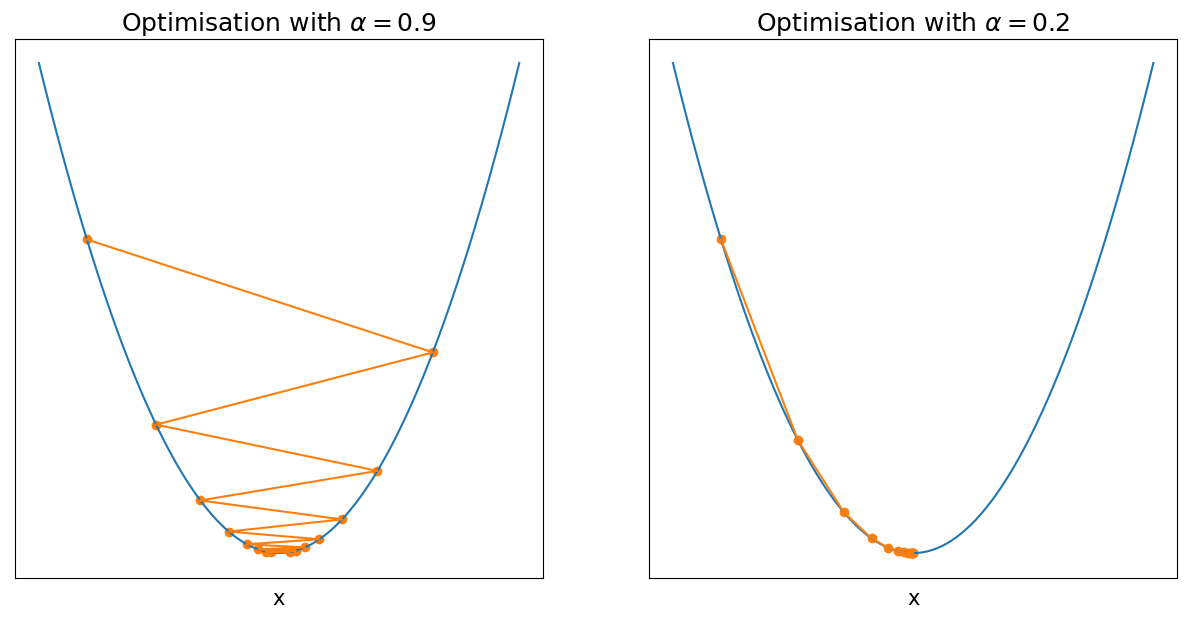

In [1574]:
xs = np.linspace(-100, 100, 101)

x0 = -80
x_trace_1 = optimise(x0, alpha=0.9, num_steps=14)
x_trace_2 = optimise(x0, alpha=0.2, num_steps=14)

plt.figure(figsize=(15, 7))

plt.subplot(121)

plt.title(r"Optimisation with $\alpha=0.9$")
plt.plot(xs, q(xs))

plt.plot(x_trace_1, q(x_trace_1))
plt.scatter(x_trace_1, q(x_trace_1), color=colors[1])

plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("x")
# plt.ylabel("f(x)")

plt.subplot(122)
plt.title(r"Optimisation with $\alpha=0.2$")
plt.plot(xs, q(xs))

plt.plot(x_trace_2, q(x_trace_2))
plt.scatter(x_trace_2, q(x_trace_2), color=colors[1])

plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("x")
# plt.ylabel("f(x)")

plt.show()

Both examples use the same function \\(\,f(x)\\), and both optimisations start at the same point \\(x_0\\). They only differ by the parameter \\(\alpha\\), which controls the step size. These examples highlight how sensitive our optimisation can be to the choice of \\(\alpha\\). In fact, for this example, if you pick any \\(\alpha > 1\\), the optimization won't even converge to the minimum. On the other hand, if the \\(\alpha\\) is too small, it will take us forever to get to the minimum.

The natural question to ask is whether we can avoid setting \\(\alpha\\) ourselves. Many algorithms can help us address the problem, and in the next section, we will focus on one of these algorithms.

### Newton's method

For many people, [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) is introduced as a method that allows one to find an approximation of the root of a function \\(\,f\\). Instead, we will focus on the roots of the derivative function \\(\,f'\\). Roots of the derivative are also known as [stationary points](https://en.wikipedia.org/wiki/Stationary_point), and the local minimum is one of them. 

As with the gradient descent, the method is iterative, and with each iteration, we try to improve our guess about the minimum of the function. We can describe this family of iterative solutions with a simple equation \\(\,x_{t+1} = x_t + \Delta_t\\), where for the gradient descent \\(\Delta_t=-\alpha f'(x_t)\\). In addition, we can take our generalisation one step further. For example, we can view gradient descent as a method that locally approximates the function at point \\(x_t\\) with a line and follows the direction of the descent. We can also think of it as a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) of function \\(f\\), trimmed after the first two terms

$$
f(x_t + \Delta_t) \approx f(x_t) + f'(x_t)\Delta_t
$$

Notice that by plugging \\(\Delta_t\\) from the gradient descent equation, we can show that value of this locally approximated function decreases.

$$
f(x_t -\alpha f'(x_t)) \approx f(x_t) - \alpha f'(x_t)^2 \le f(x_t)
$$

Please note the equation above doesn't imply that \\(\,f(x_{t+1}) \le f(x_t)\\), since the approximation sign is non-transitive.

Newton's method is very similar to the gradient descent from this perspective. The only difference is that we consider the first three terms of the Taylor series rather than two.

$$
f(x_t + \Delta_t) \approx f(x_t) + f'(x_t)\Delta_t + \frac{1}{2}f''(x_t)\Delta_t^2 
$$

We can compute the derivative with respect to the direction \\(\Delta_t\\) and find that it's equal to zero when

$$
\Delta_t = -\frac{f'(x_t)}{f''(x_t)} = -\frac{g_t}{h_t}
$$

As in the previous section, the first and second-order derivatives were replaced with \\(g\\) and \\(h\\) variables (where \\(h\\) stands for "Hessian"). And with a known \\(\Delta_t\\) we arrived at the following iterative formula which people call "Newton's method"

$$
x_{t+1} = x_t - \frac{g_t}{h_t}
$$

Here is what one step of the method might look like

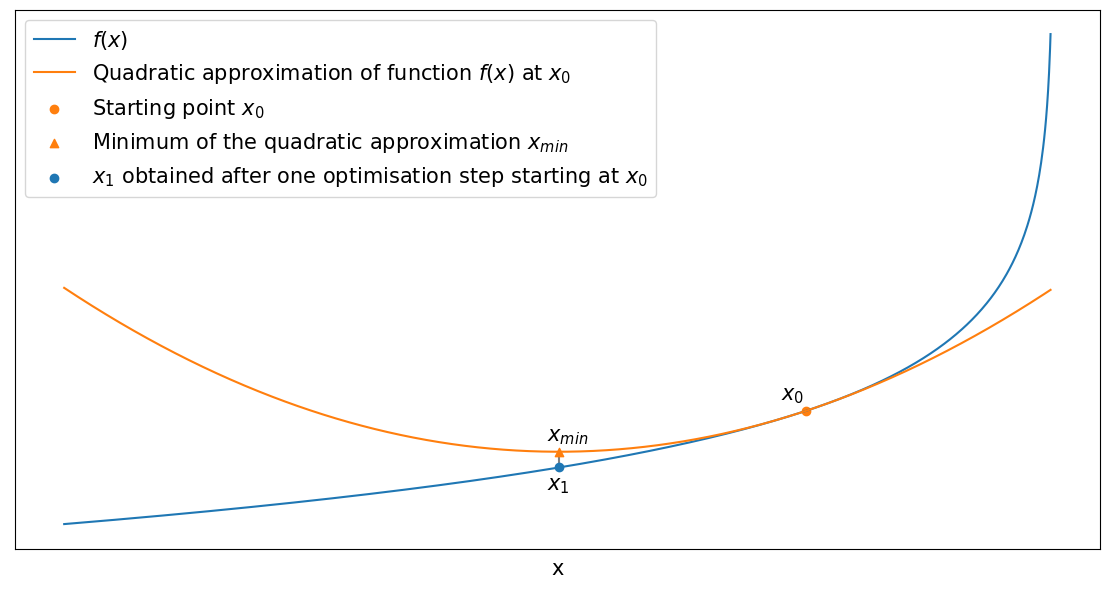

In [1573]:
def f(x, p):
    return -p * np.log(x) - (1-p) * np.log(1 - x)

def f_prime(x0, p):
    return (x0 - p)/(x0*(1-x0))

def f_double_prime(x0, p):
    return (p - 2*p*x0 + x0**2)/((x0*(1-x0))**2)

def s(x, x0, p):
    a0 = f(x0, p)
    a1 = f_prime(x0, p)
    a2 = f_double_prime(x0, p)

    return 0.5*a2 * (x-x0)**2 + a1 * (x-x0) + a0

p = 0.1
x0 = 0.99
x = np.linspace(0.96, 1, 1001)
x = np.clip(x, 1e-4, 1 - 1e-4)
y = f(x, p)

plt.figure(figsize=(14, 7))
plt.plot(x, y, label=r"$f(x)$")
plt.plot(x, s(x, x0, p), label=r"Quadratic approximation of function $f(x)$ at $x_0$")
plt.scatter([x0], f(x0, p), color=colors[1], label="Starting point $x_0$")
plt.gca().annotate(r"$x_0$", [x0 - 0.001, 0.12 + f(x0, p)])
    
x1 = x0 - f_prime(x0, p) / f_double_prime(x0, p)

x_min = s(x1, x0, p)
plt.scatter([x1], [x_min], marker="^", color=colors[1], label="Minimum of the quadratic approximation $x_{min}$")
plt.gca().annotate(r"$x_{min}$", [x1 - 0.0005, x_min + 0.12])

plt.plot([x1, x1], [f(x1, p), x_min], "-", zorder=-2, color="grey")

plt.scatter([x1], [f(x1, p)], color=colors[0], label="$x_1$ obtained after one optimisation step starting at $x_0$")
plt.gca().annotate(r"$x_1$", [x1 - 0.0005, f(x1, p) - 0.25])

plt.xlabel("x")
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.show()

Now let's go back and look again at the new update rule

$$
x_{t+1} = x_t - \frac{g_t}{h_t}
$$

Notice that our new update rule looks similar to the gradient descent update if we set \\(\alpha = 1/h_t\\). Except now, \\(\alpha\\) is no longer a constant and depends on time \\(t\\), which means that the step size can "adapt" to the changes over time. You might remember from the calculus class that the first-order derivative tells us how quickly the output of the function \\(\,f\\) changes at some point \\(x_t\\) if we start making infinitesimal changes to the input. Likewise, the second-order derivative tells us the same information, only now, about the derivative function \\(\,f'\\). In other words, it tells us how quickly a first-order derivative increases or decreases if we start making infinitesimally small changes to the point \\(x_t\\). To gain a better understanding, let's consider two cases.

First case: the second-order derivative is small at \\(x_t\\). It tells us that if we start moving to a new position \\(x_{t+1}\\), which is close to \\(x_t\\), then we might expect that a derivative \\(g_{t+1}\\) at the new position is very similar to the derivative \\(g_t\\) at last position \\(x_t\\). With gradient descent, our change between two points must be

$$
x_{t+1} - x_t = -\alpha g_t
$$

We can take another step and measure the difference between two positions \\(x_{t+1}\\) and \\(x_{t+2}\\)

$$
x_{t+2} - x_{t+1} = -\alpha g_{t+1}
$$

But previously, we said that since the second-order derivative is small, then \\(g_t \approx g_{t+1}\\) and we can find that

$$
\begin{align}
x_{t+1} - x_t = -\alpha g_t &\approx -\alpha g_{t+1} = x_{t+2} - x_{t+1} \\
x_{t+1} - x_t &\approx  x_{t+2} - x_{t+1}
\end{align}
$$

The obvious implication is that we don't need to take two steps. Instead, we can take one step but double our step size. Mathematically speaking, we get

$$
-2 \alpha g_t = 2(x_{t+1} - x_t) \approx x_{t+2} - x_{t}
$$

Remember that we started with the assumption that the second order derivative is small, and by following the gradient descent algorithm, we were able to derive that we can increase our step size and take one large step rather than a couple of small steps. Therefore, we conclude that if a second derivative is small, the step size must be large.

Consider the second case: the second-order derivative is large at \\(x_t\\). In this case, we have quite the opposite expectation. We might expect that \\(g_{t+1}\\) might be very different from \\(g_{t}\\) even if \\(x_{t+1} - x_{t}\\) is small. In that case, we need to be more careful and take a smaller step in the direction towards which the first derivative points. Following this logic, we can conclude that we must select a small step size \\(\alpha\\) if the second-order derivative is large.

I hope that at this point, it becomes clearer why using \\(\alpha=1/h_t\\) might be a good idea. For example, if \\(h_t\\) is very large, then \\(\alpha\\) must be very close to zero, just like in our previous example. On the contrary, if the \\(h_t\\) is small, it's better to have \\(\alpha\\), which is very large.

Consider the two graphs below

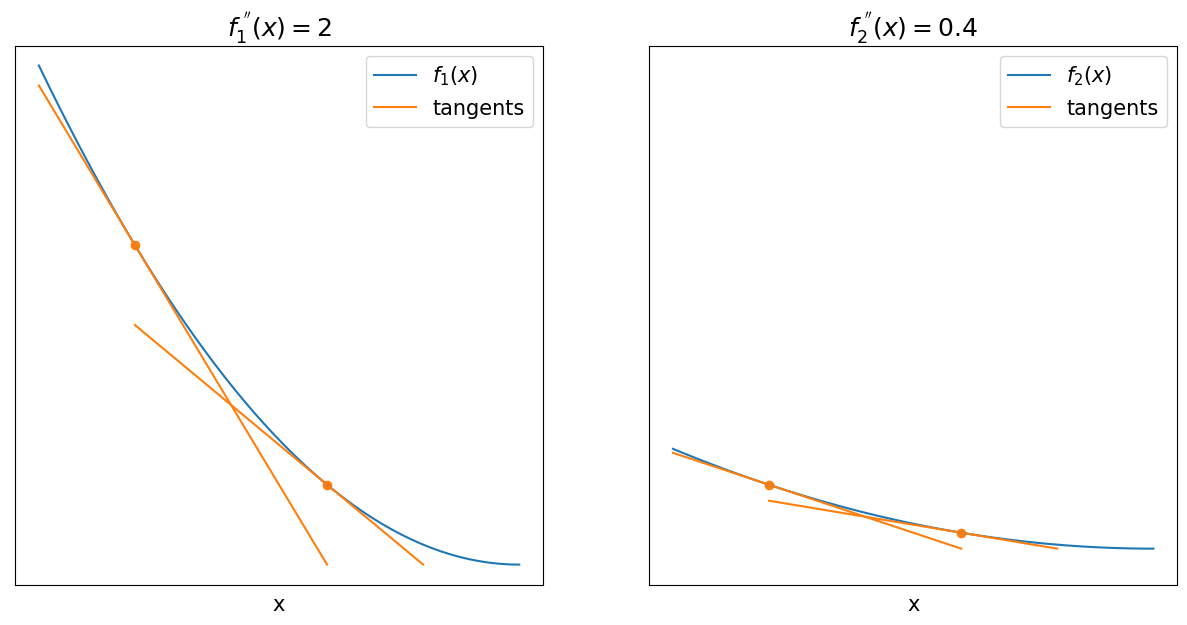

In [1606]:
plt.figure(figsize=(15, 7))
xs = np.linspace(-5, 0)

plt.subplot(121)
plt.plot(xs, q(xs), label="$f_1(x)$")

plt.title(r"$f_1^{\,\,''}(x)=2$")
plt.ylim(-2, 25)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("x")
# plt.ylabel("$f_1(x)$")

plt.scatter([-4, -2], [q(-4), q(-2)], color=colors[1])
plt.plot([-5, -2], [q(-4) + 8, q(-4) - 2*8], color=colors[1], label="tangents")
plt.plot([-4, -1], [q(-2) + 2*4, q(-2) - 4], color=colors[1])
plt.legend()

plt.subplot(122)

coef = 0.2
plt.plot(xs, coef * q(xs), label="$f_2(x)$")

plt.scatter([-4, -2], [coef*q(-4), coef*q(-2)], color=colors[1])
plt.plot([-5, -2], [coef*q(-4) + 4 * 2 * coef, coef*q(-4) - 2*4 * 2 * coef], color=colors[1], label="tangents")
plt.plot([-4, -1], [coef*q(-2) + 2*2*2*coef,coef*q(-2) - 2 * 2 * coef], color=colors[1])

plt.title(rf"$f_2^{{\,\,''}}(x)={2*coef}$")
plt.ylim(-2, 25)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("x")
plt.legend()
# plt.ylabel("$f_2(x)$")

plt.show()

The image shows two quadratic functions \\(f_1(x)=x^2\\) and \\(f_2(x)=0.2x^2\\). In addition, each graph highlights two points as well as their tangents. You can see that a graph on the right has a smaller change in first-order derivative (i.e., the angle between the tangents is smaller).

The method looks like a noticeable improvement to the gradient descent, but there is one big problem. Some of you might have noticed it already, but for the others, let me ask you this, what will happen if \\(h_t \le 0\\)? The problem is apparent when \\(h_t = 0\\), but less evident with \\(h_t \lt 0\\). Remember that previously, we said that \\(-g_t\\) points to the direction along which function decreases, so the negative sign of the \\(h_t\\) will negate the effect and send us in the opposite direction. In general, the algorithm will search for the stationary point, which might not be a minimum, so it will be essential to add a restriction to ensure every stationary point is a minimum. Specifically, we will add a constraint that function \\(f\\) is [strictly convex](https://en.wikipedia.org/wiki/Convex_function). Convexity of the function will ensure that \\(h_t \gt 0\\), which would help us to eliminate the problems mentioned above.

## Sum of squared error (SSE)

Before we finally get into the details of the XGBoost paper, it will be important to cover one last topic. Specifically, we will be interested in the special families of the functions, which are quite often called sum of squared errors (SSE).

### Regular SSE

Let's imagine playing a simple game where we have \\(N\\) cards with numbers \\(y_i\\) on them, where \\(i \in \\\{1, 2, ..., N\\\}\\). One card is being pulled from the deck randomly, and before we see it, we need to make a guess \\(x\\) of what the number on the card could be. The magnitude of the mistake can be judged by taking the square of the difference between the observed number \\(y_i\\) and our guess \\(x\\). Since we don't know in advance which card will be pulled, we need to make a guess which is optimal for any situation. Mathematically speaking, we have the following problem

$$
\begin{align}
\mathbf{\min_x} \, \sum_{i=1}^{N} (x - y_i)^2
\end{align}
$$

Notice that our function is quadratic in \\(x\\), which means we can follow the same optimisation steps as in Newton's method section when we looked into the first three terms of the Taylor series, except there, we were looking at the minimum with respect to \\(\Delta_t\\) instead of \\(x\\). If we repeat the same steps from the previous section, we will get the following result

$$
x^* = \frac{1}{N} \sum_{i=1}^{N} y_i
$$

The solution implies that if we want to minimise SSE and we're allowed to make only one guess, then the average of the observations is the best that we can hope for.

### Weighted SSE

We can take the problem further and consider a weighted SSE. In the context of the number-guessing game, certain cards are more likely to be pulled than others. For example, if the relative frequency of each card is \\(w_i\\), then we can modify the previous optimisation in the following way

$$
\begin{align}
\mathbf{\min_x} \, \sum_{i=1}^{N} w_i (x - y_i)^2
\end{align}
$$

We can solve the new problem in the same way as before, and we will get a similar solution

$$
\begin{align}
x^{**} &= \frac{\sum_{i=1}^{N} w_i y_i}{\sum_{i=1}^{N} w_i} \\
&= \sum_{i=1}^{N} \left(\frac{w_i}{\sum_{i=1}^{N} w_i}\right) y_i \\
\end{align}
$$

Notice that if we set \\(w_i=1\\), then we obtain our previous solution \\(x^*\\).

The solution shows that for the new problem, we must consider the weighted average of the observations \\(y_i\\), which is a very intuitive extension of the previous solution.

### Regularised SSE

Let's assume that in addition to the weighted loss, we want to put an additional constraint on the value \\(x\\). 
For example, let's say that in addition to making a guess \\(x\\), we would also have to pay an equal amount of money for that guess. So if we guess \\(x=3\\), we would have to pay three units of currency for it. This rule change would force us to make our guess closer to 0. We can enforce this behaviour with a soft constraint to our previous objective, and in the later sections, we will refer to it as "regularisation"

$$
\begin{align}
\mathbf{\min_x} \, \sum_{i=1}^{N} w_i (x - y_i)^2 + \lambda x^2
\end{align}
$$

where \\(\lambda\\) is a positive constant that controls the strength of the regularisation (e.g., the larger the value, the stronger the regularisation effect will be). Now notice that we can think of the regularisation term as a new data point with index \\((N+1)\\) for which \\(y_{N+1}=0\\), \\(w_{N+1}=\lambda\\). We can apply solution \\(x^{**}\\) for the regularised weighted SSE as well, and we get

$$
\begin{align}
x^{***} &= \sum_{i=1}^{N} \left(\frac{w_i}{\lambda + \sum_{i=1}^{N} w_i}\right) y_i
\end{align}
$$

The key takeaway from this section is that whenever we encounter a squared error function in the following discussions, we always need to remember that some form of averaging will be part of the solution.

And now, we finally have all the basic knowledge needed to understand the Gradient Boosting Decision Trees.

## Gradient Boosting Decision Trees

Gradient Boosting Decision Trees (GBDT) is an algorithm that uses examples of inputs \\(x_i \in \mathbb{R}^m\\) and respective outputs \\(y_i \in \mathbb{R}\\) to learn a general mapping from \\(x_i\\) to \\(y_i\\) (i.e. \\(y_i = F(x_i)\\)). For example, we want to know the price \\(y_i\\) of a used item, given some information \\(x_i\\) about the item (type of a product, number of years in use, etc.). For typical real-world problems, a perfect mapping from \\(x_i\\) to \\(y_i\\) might not exist, in which case we want to get an approximation \\(\widehat y_i = F(x_i)\\), where \\(\widehat y_i\\) is "close" to \\(y_i\\). Of course, the interpretation of the word "close" would depend on the task, but in general, we will have some loss function which would take \\(\widehat y_i\\) and \\(y_i\\) as input and would tell us how bad the guess \\(\widehat y_i\\) (a.k.a. prediction) is compared to the actual value \\(y_i\\) (just like SSE in the number-guessing game).

As with any other machine learning algorithm, GBDT restricts the space of choices of the function \\(F\\) to a specific family of functions. It constructs \\(F\\) from a sequence of \\(K\\) additive trees, which have the following form

$$
\widehat y_i = F(x_i) = \sum_{k=1}^{K} f_k(x_i)
$$

where \\(\,f_k\\) is a k-th decision tree. Each tree also has a special functional form which we will discuss in the next section.

### Decision Trees

[Decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) \\(\,f_k\\) partitions input space \\(X\\) into a finite number of \\(T_k\\) regions. All samples within one particular region \\(r\\) will have the same output from the function \\(f_j\\). 

$$
w_{kr} = f_k(x_i)
$$

where \\(w_{kr} \in \\\{w_{k1}, w_{k2}, ..., w_{kT_k}\\\}\\). It's important to emphasise that for our problem, \\(w_{kr}\\) are one-dimensional quantities, although they don't have to be in general. In addition, space partitions are always perpendicular to one dimension and parallel to the other.

It's rather easy to visualise these functions. For example, \\(x_i\\) is a two-dimensional vector, and we constructed a tree \\(\,f_k\\) which partitions space into \\(T_k=4\\) regions. Here is what such a space partition might look like

In [11]:
# from sklearn.datasets import make_blobs
# X, _ = make_blobs(n_samples=100, centers=4, cluster_std=0.60, random_state=0)
X = [[0.67, -2.02, 1.43, 1.07, 1.71, 0.74, -2.04, -0.68, -0.05, -1.47, -0.86, -1.85, -1.27, -0.93, -0.73, 3.19, 1.35, -0.1, -1.93, 2.74, 2.34, -1.94, -1.99, 2.33, 0.44, -1.59, -0.37, 0.77, 2.95, 2.76, 1.65, -0.87, 2.16, 2.06, -1.16, 1.16, -1.55, 1.81, 0.05, -1.97, 1.06, -1.43, -1.63, -2.07, -1.94, -1.98, 1.53, -1.91, 0.67, 0.44, 0.22, 1.87, -1.18, -1.79, -0.85, -1.26, -0.79, 2.49, 2.27, -0.54, -1.46, 1.41, 2.13, 1.9, 1.29, -0.59, -2.32, -1.29, 2.18, 1.24, -1.87, 1.36, 0.91, -1.52, 1.0, 1.49, -0.41, -1.69, 2.3, 1.08, 1.57, -1.69, -1.35, 0.01, 1.67, -0.96, 1.51, 1.81, 1.87, 1.02, 0.96, -1.3, 0.35, -1.12, -2.42, -1.91, -1.73, -1.57, -0.7, -0.56], [3.6, 8.0, 4.38, 4.53, 5.03, 4.12, 4.06, 7.89, 5.47, 7.69, 6.87, 6.91, 7.13, 7.73, 7.44, 0.09, 2.06, 3.48, 2.94, 0.16, 3.43, 7.57, 3.24, -0.02, 4.54, 2.52, 3.81, 4.4, 2.04, 0.79, 0.68, 6.87, 0.66, 1.97, 3.47, 3.79, 8.99, 1.63, 8.64, 2.42, 5.18, 3.3, 6.5, 3.59, 2.83, 8.34, 0.55, 3.32, 4.04, 3.12, 4.77, 0.93, 2.79, 4.03, 2.27, 7.39, 8.33, 0.98, 1.32, 8.03, 7.01, 1.53, 1.14, 5.19, 1.48, 8.23, 2.64, 2.26, 1.48, 4.5, 8.24, 1.44, 4.55, 7.85, 4.19, 3.86, 3.46, 3.4, 0.49, 1.18, -0.14, 8.76, 3.71, 4.18, 0.68, 2.82, 0.93, 0.45, 4.18, 4.49, 4.56, 2.26, 3.45, 3.16, 3.18, 7.87, 7.42, 3.95, 8.03, 4.7]]
X = np.array(X).T

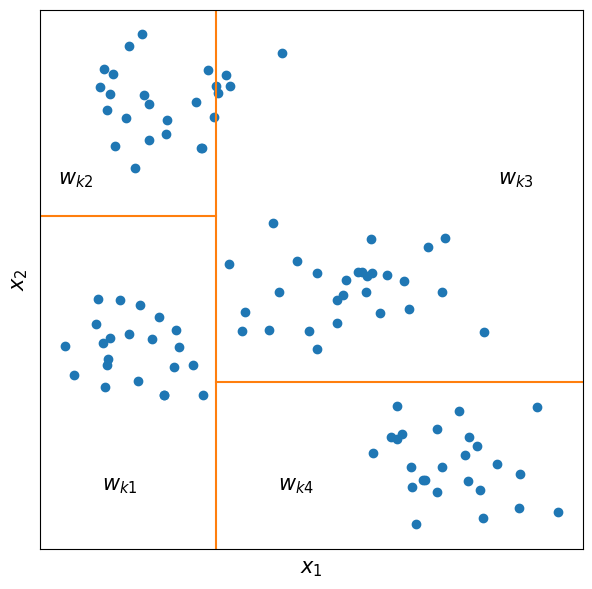

In [12]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

plt.scatter(*X.round(2).T)
left, right = ax.get_xlim()

ax.axvline(-0.7, color=colors[1])
plt.plot([-0.7, right], [2.5, 2.5], color=colors[1])
plt.plot([left, -0.7], [5.6, 5.6], color=colors[1])

ax.annotate(r"$w_{k1}$", [-2, 0.5])
ax.annotate(r"$w_{k2}$", [-2.5, 6.2])
ax.annotate(r"$w_{k3}$", [2.5, 6.2])
ax.annotate(r"$w_{k4}$", [0, 0.5])

plt.xlim(left, right)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.xticks([], [])
plt.yticks([], [])
plt.show()

From the definition and example above, it should be rather obvious what the function does. Specifically, it checks in which of the partitions the point \\(x_i\\) falls to and returns a number \\(w_{kr}\\) which is associated with that partition. So, for example, in the image above, all points in the largest square at the top right will have an identical output, namely \\(w_{k3}\\).

We assumed that the tree's structure is known, but in practice, we have also to construct it from data. The XGBoost paper describes how the tree can be built, and to avoid having too many topics discussed in this article, I won't be going into details. For now, it will be enough to have an intuition of the decision tree, but later in the article, we will have to return to this topic.

### Loss function

Space partitioning and predictions \\(w_{kr}\\) make sense only within a context of a particular problem. That's why we must define our objective by introducing a loss function. XGBoost uses the following loss function \\(\mathcal{L}\\)

$$
\mathcal{L}(\phi) = \sum_{i=1}^{N} l(y_i, \widehat y_i) + \sum_{k=1}^{K} \Omega(f_k) \\
\Omega(f_k) = \gamma T_k + \frac{1}{2} \lambda \sum_{r=1}^{T_k} w_{kr}^2
$$

The function \\(\,\mathcal{L}\\) is more straightforward than it looks. We can break it down into simpler functions and understand them separately. The function \\(l\\) measures how bad of an approximation \\(\widehat y_i\\) compare to \\(y_i\\). For example, it can be a squared error \\(l(y_i, \widehat y_i) = (y_i - \widehat y_i)^2\\), just like the one we saw in the SSE section. The function \\(l\\) must be convex with respect to the \\(\widehat y_i\\). If you recall, the convexity of the function \\(l\\) will guarantee that the second-order derivative is positive, which will be essential for the final solution. The sum overall all individual losses \\(l(y_i, \widehat y_i)\\) measures loss on all available data, and we want to minimise it as much as possible.

The second part is a regularisation function \\(\Omega(f_k)\\) associated with each tree \\(\,f_k\\). The first part of the regularisation \\(\gamma T_k\\) ensures that the model doesn't just memorise our examples (e.g., we want to avoid having \\(T_k=N\\)). Memorisation will make it difficult to generalise function for the unseen inputs \\(\,x'\\). Therefore we need to penalise the number of space partitions in order to avoid having too many. That's exactly what \\(\gamma T_k\\) does, and we can control the penalty with a hyperparameter \\(\gamma\\). The larger the \\(\gamma\\), the fewer partitions we would want to have. This regularisation allows us to introduce a trade-off between the complexity of the tree and its performance on the target task. So if we want to introduce one additional partition to the tree, the loss will be increased exactly by \\(\gamma\\) (use \\(T_k+1\\) instead of \\(T_k\\)). In this case, for the partition to be beneficial, the overall loss \\(\sum_{i=1}^{N} l(y_i, \widehat y_i)\\) needs to decrease by more than \\(\gamma\\), otherwise additional partition is not very helpful.

We can see that the last regularisation term \\(\lambda \sum_{r=1}^{T_k} w_{kr}^2\\) also depends on the number of partitions \\(T_k\\), and the more partitions we have, the stronger effect of the regularisation will be. Unlike the previous \\(\gamma T_k\\) term, the main purpose of this regularisation term is not to restrict a number of partitions but rather introduce a strong bias of the output from a partition towards zero when there are very few samples within the partition. Basically, the fewer samples we have within a partition, the more we will want to bias its output toward zero. In the later sections, we will understand how to derive and interpret optimal \\(w_{kr}\\), and we will see that it aggregates some "information" within the partition. Since statistics computed from the small sample are highly unreliable, it will be less risky to return numbers close to zero, which is the main reason for having this term in the regularisation function.

### Symmetry breaking

Remember that decision trees are additive, which means that the order in which the individual predictions are added is unimportant. In addition, it can be possible that individual tree predictions \\(w_{kr}\\) can be adjusted such that overall prediction \\(\widehat y_i\\) is not affected (e.g., use \\(w_{kr}+1\\) and \\(w_{(k+1)r}-1\\) for all \\(r\\)). These types of symmetries typically create a problem since the selected solution might become suboptimal if too many options give the same result. We can solve the problem by breaking the symmetry between solutions. The approach described in the paper follows sequential learning, meaning trees are trained one after another, and we no longer have previously mentioned problems.

First of all, we can make a recursive definition of \\(\widehat y_i\\)

$$
\widehat y_i^{(k)} = \widehat y_i^{(k-1)} + f_{k}(x_i)
$$

With the sequential learning approach, we need to consider \\(K\\) loss functions for each tree in a sequence. We will get the following objective for the \\(k\\)-th tree

$$
\begin{align}
\mathcal{L}^{(k)} &= \sum_{i=1}^{N} l\left(y_i, \widehat y_i^{(k)}\right) + \Omega(f_k) \\
                  &= \sum_{i=1}^{N} l\left(y_i, \widehat y_i^{(k-1)} + f_{k}(x_i)\right) + \Omega(f_k) \\
\end{align}
$$

where \\(y_i^{(k-1)}\\) is known and \\(\widehat y_i^{(0)}=0\\) (although the initial value could be any real number). Each new tree is added as an adjustment to the sum of the previously learned \\(k-1\\) trees. Specifically, our goal is to correct \\(y_i^{(k-1)}\\) with a new tree \\(f_{k}\\) so that the overall loss \\(\mathcal{L}^{(k)}\\) gets smaller.

### Approximation of the loss function

The final solution in the XGBoost paper requires us to simplify the loss \\(\mathcal{L}^{(k)}\\). We want to apply the same trick we did in the "Newton's method" section. Specifically, we make Taylor series expansion of each function \\(l\\) around a fixed point \\(c\\) and trimm it after three terms

<div class="side-scroll">
$$
l\left(y_i, x\right) \approx l(y_i,c) + g_i(x-c) + \frac{1}{2}h_i (x-c)^2
$$
</div>

where \\(g_i\\) and \\(h_i\\) are first and second-order derivatives of \\(l\\) with respect to the second argument and evaluated at \\(c\\). If we set \\(c = \widehat y_i^{(k-1)}\\), \\(x = \widehat y_i^{(k-1)} + f_k(x_i)\\) and plug them into the loss \\(\mathcal{L}^{(k)}\\) we will get

<div class="side-scroll">
$$
\begin{align}
\mathcal{L}^{(k)} \approx \sum_{i=1}^{N} \left[l(y_i, \widehat y_i^{(k-1)}) + g_i f_{k}(x_i) + \frac{1}{2}h_i f_{k}(x_i)^2\right] + \Omega(f_k)
\end{align}
$$
</div>

Recall that \\(\,f_k(x_i)=w_{kr}\\) is a one-dimensional variable which means that if we assume that the structure of the tree is known (i.e., we know precisely how it partitions the space), then all we need to do is to find a \\(w_{kr}\\) for each partition such that the loss is minimised. Again, that's highly similar to Newton's method, and we can apply the same solution, but there is another way to solve the problem. We can rearrange the terms by completing the square and find that our approximate loss function is a regularised and weighted SSE.

<div class="side-scroll">
$$
\begin{align}
\mathcal{L}^{(k)} & \approx \frac{1}{2} \sum_{i=1}^{N} h_i \left(f_{k}(x_i) + \frac{g_i}{h_i}\right)^2 + \Omega(f_k) + C \\
                  &= \frac{1}{2} \sum_{i=1}^{N} h_i \left(f_{k}(x_i) - \left(-\frac{g_i}{h_i}\right)\right)^2 + \Omega(f_k) + C
\end{align}      
$$
</div>

where the term \\(C\\) is independent of \\(\,f_{k}(x_i)\\) terms (i.e. \\(C=-1/2\sum_{i=1}^{N}g_i^2/h_i\\))

### Optimial \\(w_{kr}\\)

Although \\(\mathcal{L}^{(k)}\\) is a regularised and weighted SSE, we cannot quite apply the same solution as the one which we derived in the corresponding section previously. Remember that our tree \\(\,f_k\\) partitions the space into multiple regions, and each region \\(r\\) has its prediction \\(w_{kr}\\). It means that if the tree makes \\(T\\) partitions, then we can have \\(T\\) unique predictions, but in our discussion of the SSE, we assumed that only one prediction is possible. So to use the result, we can focus on losses within each partition. We can rewrite our approximate loss in the following way

<div class="side-scroll">
$$
\begin{align}
\mathcal{L}^{(k)} &\approx \sum_{t=1}^{T} \mathcal{L}^{(k)}_t + C \\
\mathcal{L}^{(k)}_t &= \frac{1}{2}\sum_{i \in I_t} h_i \left(w_{kt} - \left(-\frac{g_i}{h_i}\right)\right)^2 + \frac{1}{2}\lambda w_{kt}^2 + \gamma
\end{align}
$$
</div>

where \\(I_t\\) is a set of all samples \\(x_i\\) which are inside of the partition \\(t\\). Each sample inside of the \\(I_t\\) must have identical prediction \\(w_{kt}\\), which means that loss of the partition \\(t\\) is exactly weighted and regularised sum of squared errors for which we're allowed to make only one constant prediction, namely \\(w_{kt}\\). And because each partition can make any prediction independent from predictions in other partitions, it means that we can optimise each \\(\mathcal{L}^{(k)}_t\\) independently, which in turn means that we can apply result from the SSE section here. 

If we say that \\(h_i\\) is a weight, \\(-g_i/h_i\\) is the target and if we optimise with respect to \\(w_{kt}\\) then we get our solution

$$
\begin{align}
w_{kt}^{***} &= \sum_{i \in I_t}\left(\frac{h_i}{\lambda + \sum_{j \in I_t} h_j}\right)\left(-\frac{g_i}{h_i}\right) \\
             &= \frac{-\sum_{i \in I_t} h_i \frac{g_i}{h_i}}{\lambda + \sum_{i \in I_t} h_i} \\
             &= \frac{-\sum_{i \in I_t} g_i}{\lambda + \sum_{i \in I_t} h_i}
\end{align} 
$$

## Relation to the Newton's method

Before we tie everything together, let's briefly recap what we've done so far.

1. We started with the loss function \\(\mathcal{L}\\) which measured how close the output of the GBDT \\(\widehat y_i\\) compare to the expected output \\(y_i\\) across all of the available examples
2. We created \\(K\\) partial losses \\(\mathcal{L}^{(k)}\\) which were associated with each tree.
3. The optimisation is done sequentially, so that \\(\mathcal{L}^{(k-1)}\\) has to be optimised before we optimise \\(\mathcal{L}^{(k)}\\)
4. The \\(\mathcal{L}^{(k)}\\) loss was approximated with quadratic function. In addition, we split tree losses \\(\mathcal{L}^{(k)}\\) into losses which we associated with each partition \\(t\\) and named them \\(\mathcal{L}^{(k)}_t\\)
5. We discovered that \\(\mathcal{L}^{(k)}_t\\) can be approximated as regularised and weighted SSE, which is the same type of function that we've encountered before with the number-guessing game.

<div class="side-scroll">
$$
\begin{align}
\mathcal{L}^{(k)}_t &= \sum_{i \in I_t} h_i \left(w_{kt} - \left(-\frac{g_i}{h_i}\right)\right)^2 + \lambda w_{kt}^2 + \gamma
\end{align}
$$
</div>

Recall that in the number-guessing game, we had to make one prediction before the number was revealed. Another way to say it is that we wanted to make one guess that would be as close as possible to all available numbers. With the partition loss \\(\mathcal{L}^{(k)}_t\\) we have \\(-g_i/h_i\\) instead. The new quantity should look familiar since it's exactly the formula for the update step, which we've encountered in the section where we discussed Newton's method

$$
x_{t+1} = x_t - \frac{g_t}{h_t}
$$

A single partition of the \\(k\\)-th tree will have \\(|I_t|\\) points \\(x_i\\)(quantities \\(x_i\\) and \\(x_t\\) are not related). For each point \\(x_i\\), we have a prediction \\(\widehat y_i^{(k-1)}\\) from the previous \\((k-1)\\) trees and a loss associated with the prediction, namely \\(l(y_i, y_i^{(k-1)})\\). Suppose we wanted to optimise the function \\(l\\) with respect to our prediction using Newton's method, the first adjustment step for \\(\widehat y_i^{(k-1)}\\) would have been precisely \\(-g_i/h_i\\). For real-world problems, it's likely that \\(-g_i/h_i\\) would be different for different points within the partition. Since we have to make only one prediction per partition that optimises weighted SSE, it's natural that we will predict the average Newton step for each data point within the partition. So instead of optimising each function \\(l\\) individually, we collect multiple functions which are associated with "similar" points \\(x_i\\) into one partition group and use one average step for all of them.

But why do we need to use the weighted average? In addition, the weight is equal to the second-order derivative of the function \\(l\\), which looks a bit arbitrary. Recall from our discussion about Newton's method that second-order derivative \\(h_i\\) can tell us how predictable the change in the first-order derivative will be if we take one gradient descent step. So when the second derivative is large, we wanted to take smaller steps since it's more likely that the direction of the gradient descent steps can change. Another way to say it is that we need to be more cautious when curvature is large, and giant update steps can significantly and unpredictably affect optimisation. So now, if we have data points with large second-order derivatives, we would want to make sure that these "sensitive" points will have a more significant effect on the output and that smaller steps will not screw up optimisation for less sensitive cases, which is a better solution as opposed to taking optimal steps for some optimisation tasks and potentially doing damage to the other.

Surprisingly \\(\mathcal{L}^{(k)}_t\\) is not the only place where we encountered a connection with Newton's method. In fact, we had to do quite a bit of extra work to get to the solution, even if it helped us deepen our understanding of GBDT. Let's look again at solution <span>\\(w_{kt}^{***}\\)</span>, which we derived from the approximated loss.

$$
w_{kt}^{***} = \frac{-\sum_{i \in I_t} g_i}{\lambda + \sum_{i \in I_t} h_i}
$$

Notice that this is precisely the update step of Newton's method for the original partition loss (\\(\mathcal{L}^{(k)}_t\\) without Taylor series expansion)

$$
\sum_{i \in I_t} l\left(y_i, \widehat y_i^{(k-1)} + w_{kt}\right) + \lambda w_{kt}^2 + \gamma
$$

And we didn't have to take approximation since it's already part of Newton's method. So all we had to do was take the first and the second derivative of the loss, which is easy since the derivative of the sum with a finite number of terms is always a sum of the derivatives.

## The "Blind" Gradient Descent

At this point, it's important to return to the discussion on how the partitions of the tree are being constructed. The process is done recursively by dividing partitions in the following way

1. We start with one partition, which includes all \\(N\\) points.
2. Next, we take all possible splits on each dimension of the points \\(x_i\\) and see which split into two new partitions minimises the overall loss the most. If such a split exists, we add new partitions (no split can be better than any split due to the regularisation term of the loss).
3. Repeat step 2 for each available partition until we either cannot minimise the loss further or meet some other stopping criteria.

Since the tree construction minimises loss, ideally, we will end up with a tree that has partitions that are not only grouping points \\(x_i\\) based on how close they are to each other, but also each partition will be incentivised to group points that also have similar \\(-g_i/h_i\\) quantities (since making a single prediction for the entire group will be much easier).

Let's also consider what it tells us about the entire GBDT learning process. First, we start with no trees, and every input gets a constant prediction, for example, \\(\widehat y_i^{(0)}=0\\). Next, we want to learn the first tree, and to do that, we compute \\(N\\) loss functions with respect to the constant prediction \\(\widehat y_i^{(0)}\\), namely \\(l(y_i, y_i^{(0)})\\). In addition, we derive what would be the update step using Newton's method for each loss separately. Instead of taking \\(N\\) individual updates, we group inputs \\(x_i\\) into a fixed number of partitions and replace their Newton's update steps with the weighted average step within the partition. It's important to stress that a tree will try its best to correlate similarity among inputs \\(x_i\\) with similarity among update steps \\(-g_i/h_i\\). We can finally see how the first tree learns to do the first step of Newton's method on various similar one-dimensional problems. It's reasonable that the method wants to come up with the step that will be a good compromise for all inputs within the partition and, hopefully, will be a good step for the previously unseen input \\(\,x'\\), which falls within the partition.

Next, with the help of the first learned tree, we can make a new prediction \\(\widehat y_i^{(1)}\\) for each point \\(x_i\\). Now the prediction is no longer constant, but the number of distinct values will be bounded by the number of partitions of the first tree. The new and refined predictions \\(\widehat y_i^{(1)}\\) can be thought of as new positions of each one-dimensional loss function \\(l(y_i, \widehat y_i^{(1)})\\) in the optimisation process which has to be continously refined. So in the next iteration, we repeat the same steps from the previous paragraph to derive a second tree as well as new predictions \\(\widehat y_i^{(2)}\\). The process continues until all \\(K\\) trees are created. We can say that \\(k\\)-th tree learns to perform \\(k\\)-th optimisation step of Newton's method.

Newton's optimisation can be recursively unrolled into the following sum

$$
x_{t} = x_0 -\frac{g_0}{h_0} -\frac{g_1}{h_1} - ... - \frac{g_{t-1}}{h_{t-1}}
$$

And the prediction from GBDT can be unrolled into a similar sum

<div class="side-scroll">
$$
\begin{align}
F(x_i) &= \widehat y_i^{(0)} + f_1(x_{i}) + f_2(x_i) + ... + f_K(x_i) \\
       &= \widehat y_i^{(0)} -\frac{\widehat g_{i}^{(0)}}{\widehat h_{i}^{(0)}} -\frac{\widehat g_{i}^{(1)}}{\widehat h_{i}^{(1)}} - ...  -\frac{\widehat g_{i}^{(K-1)}}{\widehat h_{i}^{(K-1)}}
\end{align}
$$
</div>

Each \\(f_k\\) would come up with a reasonable suggestion for the \\(k\\)-th update of the optimisation based on its previous experience with similar optimisation problems.


Let's finish our discussion with the final visualisation, which shows how the whole GBDT process works on a toy problem. The graph below visualises a two-dimensional dataset in which each point is classified into one of two groups: blue and green.

In [1577]:
import pandas as pd
from sklearn import datasets

X, y = datasets.make_moons(n_samples=400, noise=0.2, random_state=0)
X = X - X.min(axis=0)
X = X / X.max(axis=0)


df = pd.DataFrame(X, columns=["f0", "f1"])
df["y"] = y

df.to_csv("xgboost-dataset.csv", index=None)

In [1578]:
df = pd.read_csv("xgboost-dataset.csv")
X, y = df[["f0", "f1"]].values, df.y.values

In [1579]:
x_test = np.array([0.32, 0.4])
y_test = 1

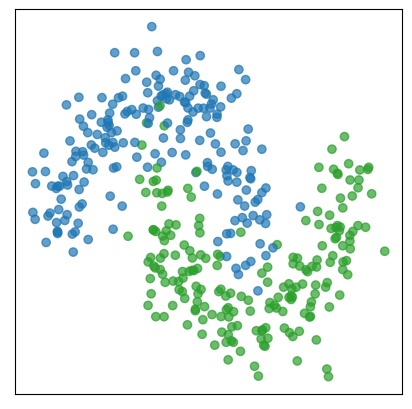

In [1580]:
plt.figure(figsize=(5, 5))

# y_visibility = 0.1 + 0.8*(y - y.min()) / (y.max() - y.min())
plt.scatter(*X.T, color=colors[y*2], alpha=0.7)
boundaries = list(plt.gca().get_xlim()) + list(plt.gca().get_ylim())

plt.xticks([], [])
plt.yticks([], [])
plt.grid();

Next, we encode each class with binary labels (zero for blue and one for green), then we can use, for example, logloss in order to have an optimisation function for each data point.

$$
l(y, \widehat y) = -y\ln(\widehat y) - (1-y)\ln(1-\widehat y)
$$

where \\(y \in \\{0, 1\\}\\) and \\(\widehat y \in (0, 1)\\). We can use the GBDT algorithm with \\(\lambda=1\\) to learn how to perform first three optimisation steps.

Visualisation below shows three optimisation iterations of the "blind" gradient descent learned by three additive decision trees. As we know, each tree partitions our input space which can be seen on the graph (left-top). In addition, we can see all data points from the previous graph and one unknown data point (colored in red). For the unknown data point, we assume that \\(y\\) is unknown, and therefore we cannot construct \\(l(y, \widehat y)\\). The right graph shows the unknown loss, our initial guess (red point), and the optimisation step selected by the GBDT from the \\(k\\)-th tree. Returning to the scatter plot on the left, you can also notice that the partition within which the unknown data point falls is highlighted. We picked twelve data points from the highlighted partition with known loss functions randomly and visualised them in one row below the previous two graphs. Each image shows the loss function, initial prediction, optimisation step selected by GBDT, and optimal step according to Newton's method.

There is more information "hidden" in these graphs, which I intentionally don't want to reveal. Instead, I hope you will be able to use graphs to test your intuition about the GBDT and discover these "hidden" details on your own.

In [1581]:
from xgboost import XGBClassifier

bst = XGBClassifier(
    n_estimators=3,
    max_depth=2,
    max_leaves=4,
    learning_rate=1,
    tree_method="exact",
    objective="binary:logistic",
    reg_lambda=1,
    subsample=1,
    alpha=0,
    seed=0,
)
bst.fit(X, y)
preds = bst.predict(X)

In [1582]:
import re
from collections import namedtuple

PARSE_SPLIT = re.compile(r"^(\d+)\:\[f(\d+)\<(-?[\d\.]+)\] yes=(\d+),no=(\d+),missing=(\d+)$")
PARSE_LEAF = re.compile(r"^(\d+)\:leaf=(-?[\d\.]+)$")

Split = namedtuple("Split", "feature_index, feature_value, yes_index, no_index, is_split")
Leaf = namedtuple("Leaf", "output, is_split")

trees = bst.get_booster().get_dump()
parsed_trees = []

for tree in trees:
    nodes = {}
    
    for node in tree.strip().split("\n"):
        node = node.strip()

        if "leaf" in node:
            node_index, output = map(float, PARSE_LEAF.findall(node)[0])
            assert node_index not in nodes
            nodes[node_index] = Leaf(output, is_split=False)

        else:
            node_index, feature_index, feature_value, yes_index, no_index, _ = map(
                float, PARSE_SPLIT.findall(node)[0])
            assert node_index not in nodes
            nodes[node_index] = Split(feature_index, feature_value, yes_index, no_index, is_split=True)
            
    parsed_trees.append(nodes)

In [1583]:
from scipy.special import expit as sigmoid

def logloss(target, logit):
    p = sigmoid(logit)
    return (-target*np.log(p)-(1-target)*np.log(1-p))

def logit(p):
    return np.log(p) - np.log(1-p)

def global_step(targets, pred, lambda_=1):
    p = sigmoid(pred)
    n = len(targets)

    grad = np.sum(p - targets)
    hess = n*p*(1-p)
    
    return -grad / (hess + lambda_)

In [1584]:
def get_leaf_index(tree, values):
    index = 0
    
    while True:
        node = tree[index]

        if not node.is_split:
            return index

        if values[int(node.feature_index)] < node.feature_value:
            index = node.yes_index
        else:
            index = node.no_index
        

In [1585]:
def plot_tree_boundaries(tree, default_boundaries, point, color, label):
    nodes = [(0, default_boundaries)]
    
    while len(nodes) > 0:
        index, boundaries = nodes.pop(0)
        node = tree[index]

        if node.is_split:
            if node.feature_index == 0:
                plt.plot([node.feature_value, node.feature_value], boundaries[-2:], c=color, label=label)
                label = ""
                nodes.append((node.yes_index, [boundaries[0], node.feature_value, boundaries[2], boundaries[3]]))
                nodes.append((node.no_index, [node.feature_value, boundaries[1], boundaries[2], boundaries[3]]))

            elif node.feature_index == 1:
                plt.plot(boundaries[:2], [node.feature_value, node.feature_value], c=color, label=label)
                label = ""
                nodes.append((node.yes_index, [boundaries[0], boundaries[1], boundaries[2], node.feature_value]))
                nodes.append((node.no_index, [boundaries[0], boundaries[1], node.feature_value, boundaries[3]]))
                
        elif point is not None:
            x, y = point
            left, right, bottom, top = boundaries
            
            if left <= x < right and bottom <= y < top:
                plt.fill_between(
                    [left, right],
                    [bottom, bottom],
                    [top, top],
                    zorder=1,
                    alpha=0.1,
                    color=colors[2],
                    label=""
                )
                
    plt.xlim(*default_boundaries[:2])
    plt.ylim(*default_boundaries[-2:])

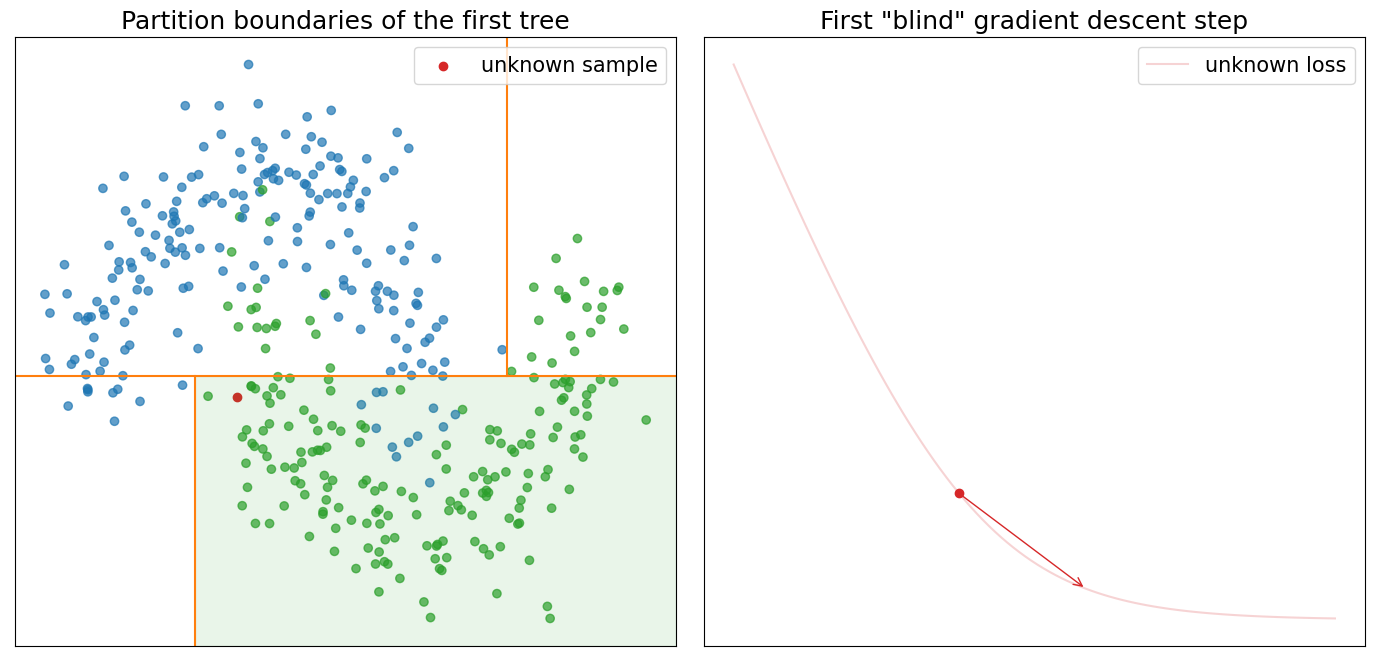

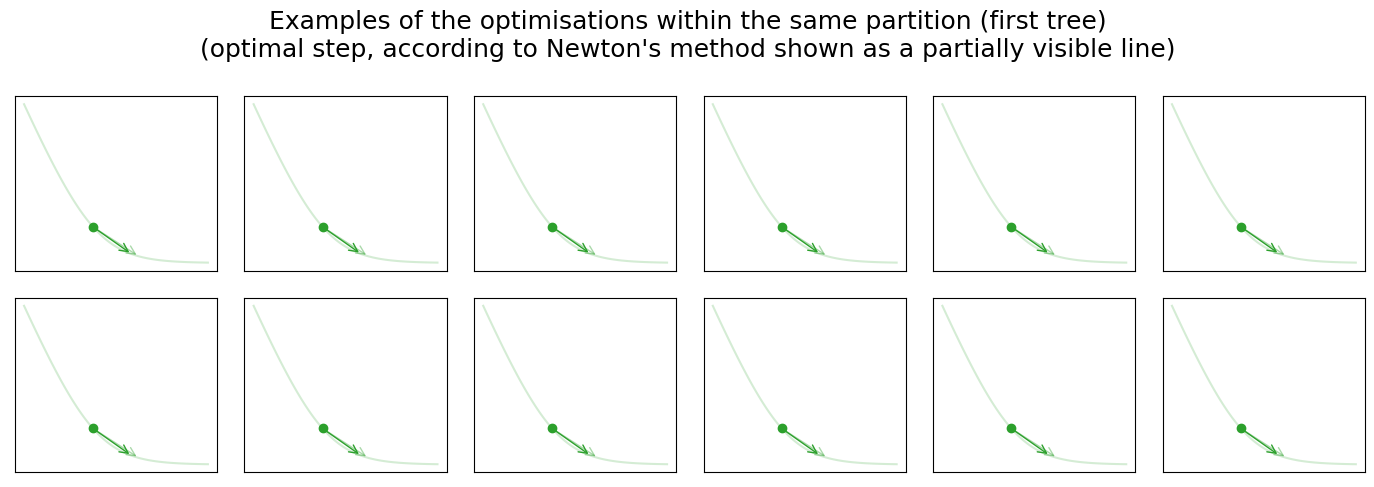

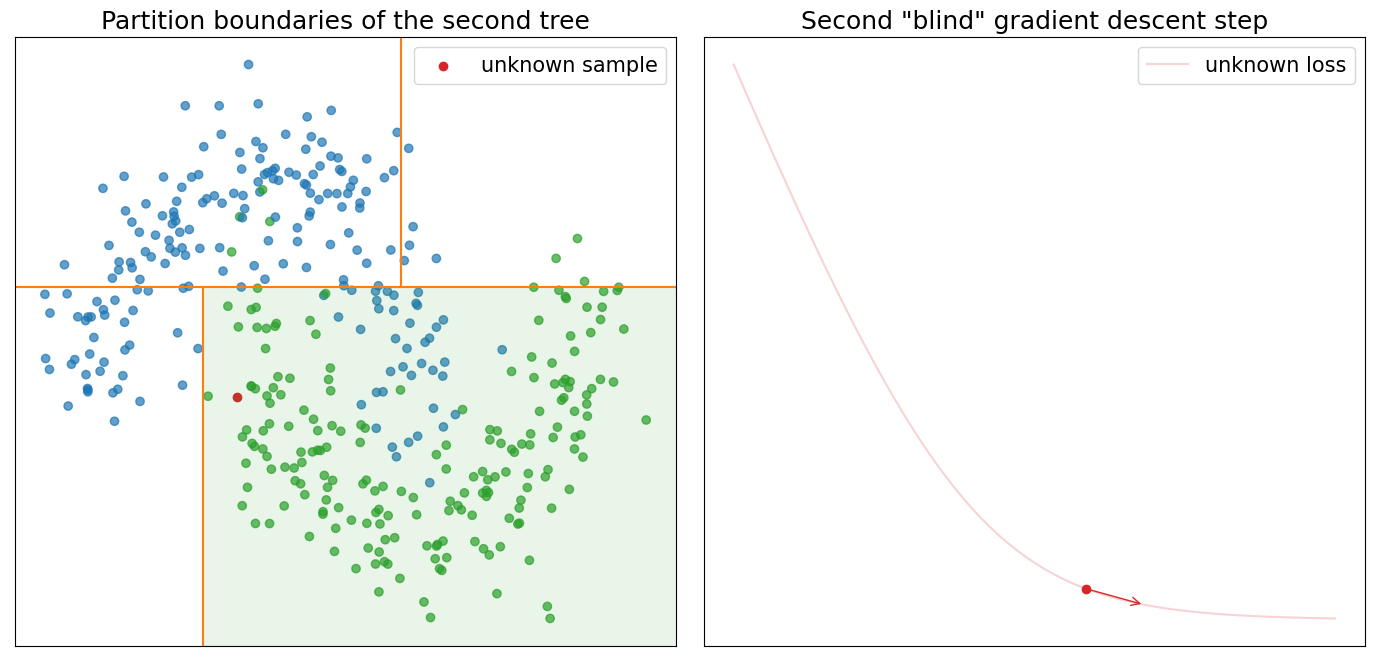

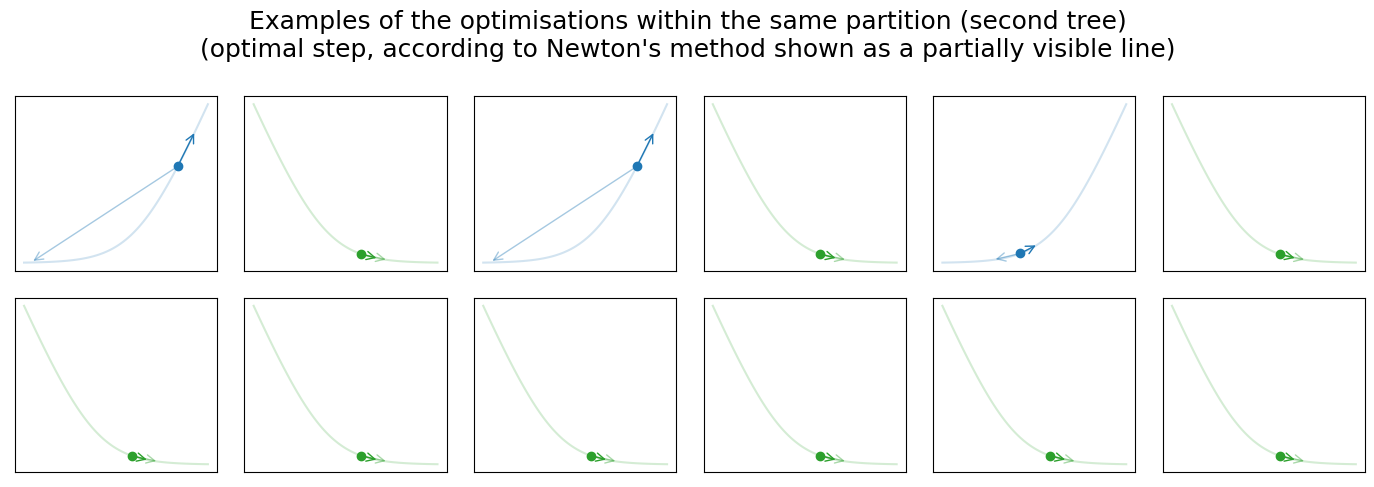

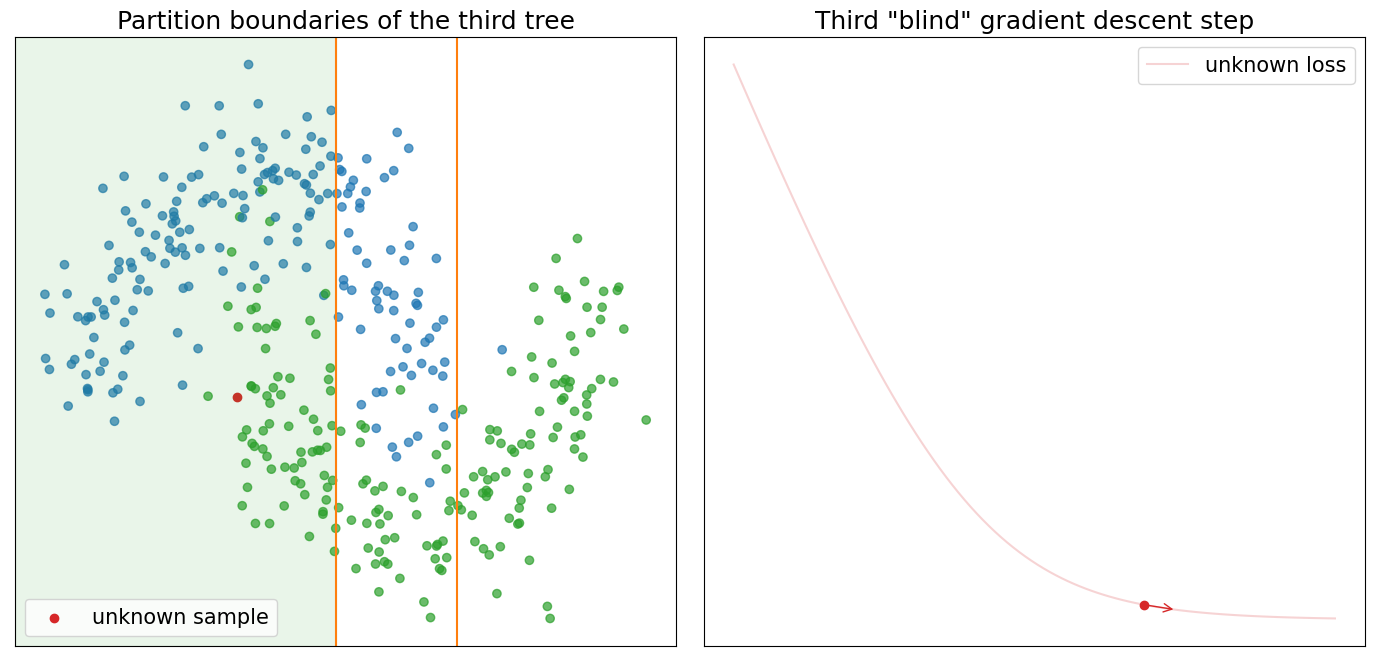

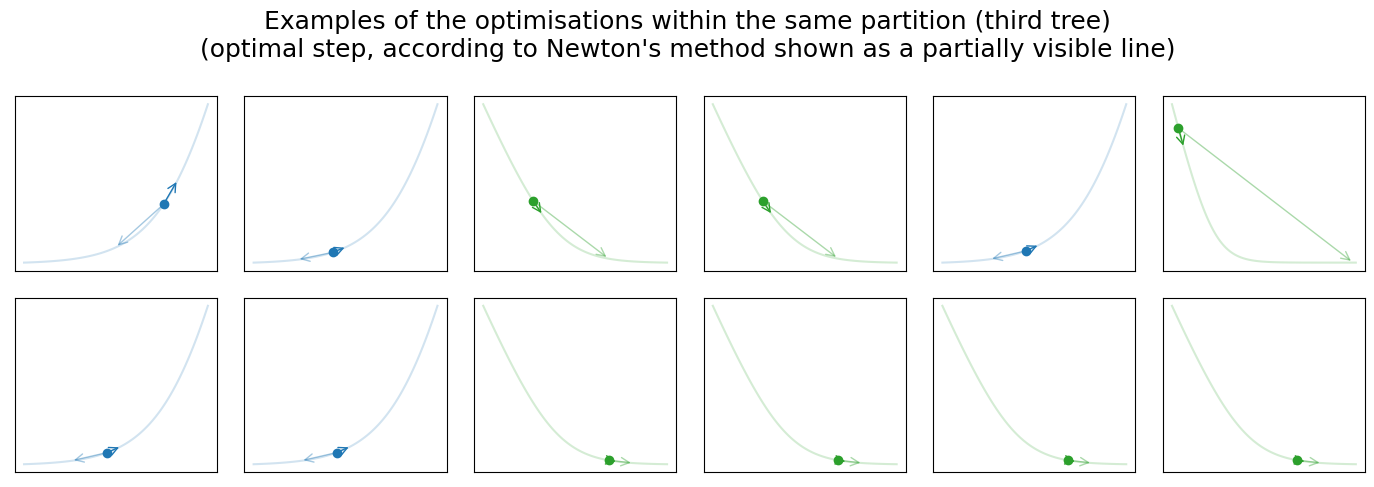

In [1593]:
def plot_arrow(x0, y0, x1, y1, **kwargs):
    plt.gca().annotate(
        "", xytext=(x0, y0), xy=(x1, y1),
        arrowprops=dict(arrowstyle="->", **kwargs),
    )

def plot_step(tree_index, x, target, y_pred_prev, y_pred, y_pred_expected=0, color=colors[0], alpha=0.2):
    x = np.asarray(x)

    if tree_index != 2:
        xmin, xmax = (-3, 5) if target else (-5, 3)
    else:
        xmin, xmax = (-3, 5) if target else (-5, 0.5)
        
    xmin = min(y_pred_prev - 0.2, xmin, y_pred - 0.2, y_pred_expected - 0.2)
    xmax = max(y_pred_prev + 0.2, xmax, y_pred + 0.2, y_pred_expected + 0.2)

    xs = np.linspace(xmin, xmax, 100)
    ys = logloss(target, xs)

    plt.plot(xs, ys, label="unknown loss", color=color, alpha=alpha)
    plt.scatter([y_pred_prev], [logloss(target, y_pred_prev)], color=color)

    plot_arrow(y_pred_prev, logloss(target, y_pred_prev), y_pred, logloss(target, y_pred), color=color)
    plt.xticks([], [])
    plt.yticks([], [])
    
y_test_pred = 0
df["y_pred"] = 0
tree_named_indices = ["First", "Second", "Third"]

for i, tree in enumerate(parsed_trees):
    fig = plt.figure(figsize=(14, 10))
    
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=2)
    plt.title(f"Partition boundaries of the {tree_named_indices[i].lower()} tree")
    plt.scatter(*X.T, color=colors[y*2], alpha=0.7)
    plt.scatter(*x_test.reshape(-1, 1), marker="o", color=colors[3], label="unknown sample")
    plot_tree_boundaries(tree, boundaries, point=x_test, color=colors[1], label="")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend()
    
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2, rowspan=2)
    plt.title(f"{tree_named_indices[i]} \"blind\" gradient descent step")
    
    y_test_pred_prev = y_test_pred
    y_test_pred = logit(bst.predict_proba(x_test.reshape(1, -1), iteration_range=(0, i+1))[:, 1]).item(0)
    plot_step(i, x_test, y_test, y_test_pred_prev, y_test_pred, color=colors[3])
    
    plt.legend()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(14, 5))
    plt.suptitle(
        f"Examples of the optimisations within the same partition ({tree_named_indices[i].lower()} tree)\n"
        f"(optimal step, according to Newton's method shown as a partially visible line)"
    )
    
    leaf_index = []

    for row in df[["f0", "f1"]].values:
        leaf_index.append(get_leaf_index(parsed_trees[i], row))

    df["leaf_index"] = leaf_index
    df["y_pred_prev"] = df["y_pred"]
    df["y_pred"] = logit(bst.predict_proba(df[["f0", "f1"]].values, iteration_range=(0, i+1))[:, 1])
    
    df_subset = df[df.leaf_index == get_leaf_index(parsed_trees[i], x_test)]
    df_subset_sampled = df_subset.sample(12, random_state=2)

    for j, row in enumerate(df_subset_sampled.itertuples()):
        ax = plt.subplot2grid((2, 6), (j//6, j%6))

        p = np.clip(sigmoid(row.y_pred_prev), 1e-7, 1 - 1e-7)
        y_pred = row.y_pred_prev + (row.y - p) / (p * (1-p))
    
        plot_arrow(
            row.y_pred_prev,
            logloss(row.y, row.y_pred_prev),

            y_pred,
            logloss(row.y, y_pred),

            color=colors[row.y*2],
            alpha=0.4,
        )
        
        plot_step(i, [row.f0, row.f1], row.y, row.y_pred_prev, row.y_pred, y_pred, color=colors[row.y*2], alpha=0.2)
        plt.xticks([], [])
        plt.yticks([], [])

    fig.tight_layout()
    plt.show()
    
    if i+1 < len(parsed_trees):
        display(HTML("<hr>"))